In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import seaborn as sns

import mne
from scipy.io import loadmat, savemat
from scipy.stats import ttest_rel, ttest_1samp, ttest_ind, kstest, wilcoxon
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import fdrcorrection

import glob
import os

import pickle
import sys

sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *


In [76]:
task = 'listen'
erp_start = -0.5
erp_end = 0.5
erp_window = '_n05to05'
fs = 128

epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data{erp_window}'

In [77]:
def create_erp_times(tmin, tmax, fs):
    """ 
    creates a time vector for ERPs given start and end time
    tmin, tmax: times in seconds
    fs: sampling frequency
    ---
    returns 1d vector with the time
    """
    step = 1 / fs
    times = np.arange(tmin, tmax+step, step)
    return times

erp_times = create_erp_times(erp_start, erp_end, fs)


In [78]:
#load subjects
good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()
subjects_to_process = good_listen_subjects

#load channels
ch_names_64, _ = load_channels()
#erp_times = load_erp_times() #this only works for the erps for -0.2 to 0.5 secs

#load standard mne info (used for channel positions)
with open('../utils/epochs_info.pkl', 'rb') as file:
    epochs_info = pickle.load(file)

In [80]:
epochs_df = load_epochs_bysubject(subjects_to_process, task=task, epochs_dir = epochs_dir)
#epochs_df = load_error_epochs_bysubject(subjects_to_process, epoch_type = 'all')


Processing subject:  01
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_01.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_01.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_01.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  02
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_02.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_02.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_02.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  03
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_03.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_03.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices availabl

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_02.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_03.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  04
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_04.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_04.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


0 projection items activated
Processing subject:  05
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_05.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_05.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  06
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_06.fif ...
    Found the data of interest:
        t =    -500.00 ...     50

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_05.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_06.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_06.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  07
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_07.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_07.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_07.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_07.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


Processing subject:  08
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_08.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_08.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_08.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  09
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_09.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_09.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_09.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_09.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  10
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_10.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_10.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


322 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  11
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_11.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_11.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  12
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_12.fif ...
    Foun

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_11.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  13
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_13.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_13.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  14
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pr

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_13.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_13.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_14.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  15
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_15.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_15.fif ...
    Found 

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_15.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_16.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_16.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  17
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_17.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compens

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_17.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  18
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_18.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_18.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  19
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pr

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_18.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_18.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_19.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  20
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_20.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_20.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF c

/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_19.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_pre_20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M

    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_21.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated


/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/pipelines_LM/../utils/ERP_utils.py:375: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05/listen_epochs_post_21.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)


In [81]:
# crop the epochs to only certain times
"""
tmax_idx = time_index([-0.1], erp_times)[0]
epochs_df['epochs'] = epochs_df['epochs'].apply(lambda x: x[:, :tmax_idx])"""

"\ntmax_idx = time_index([-0.1], erp_times)[0]\nepochs_df['epochs'] = epochs_df['epochs'].apply(lambda x: x[:, :tmax_idx])"

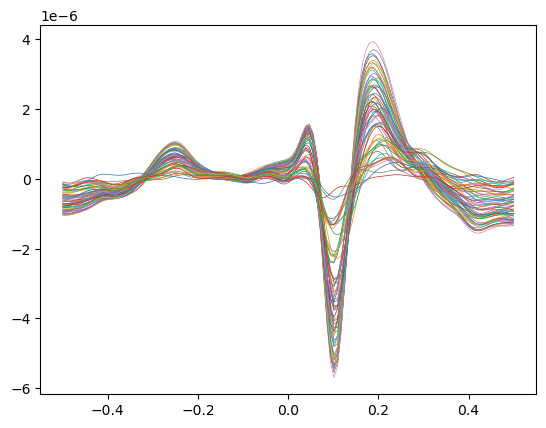

In [82]:
#sanity check

plt.plot(erp_times, np.mean(epochs_df['epochs']).T, linewidth = 0.5);


In [83]:
epochs_df.to_csv(f'{task}_epochs_by_sub{erp_window}.csv')

In [84]:
save_epochs = True
save_mat = True
save_csv = True

if save_epochs:
    if save_mat:
        musicians_pre = np.array(epochs_df.query("period == 'pre' and musician == 1")['epochs'].tolist())
        musicians_post = np.array(epochs_df.query("period == 'post' and musician == 1")['epochs'].tolist())
        nonmusicians_pre = np.array(epochs_df.query("period == 'pre' and musician == 0")['epochs'].tolist())
        nonmusicians_post = np.array(epochs_df.query("period == 'post' and musician == 0")['epochs'].tolist())
        
        savemat(f'{task}_epochs_bysubject{erp_window}.mat',{
            'mus_pre': musicians_pre,
            'mus_post': musicians_post,
            'nmus_pre': nonmusicians_pre,
            'nmus_post': nonmusicians_post,
            'fs':128,
            'erp_times': erp_times

        })
    if save_csv:
        epochs_df.to_csv(f'{task}_epochs_bysubject{erp_window}.csv')